### Use this to create graphs from results generated by the adversarial search scripts.

In [1]:
%load_ext  autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import pickle
import plot_params

In [4]:
def load_results(datafile):
    with open(datafile, 'rb') as f:
        results = pickle.load(f)
        # Remove unused data.
        results = [{
            'search_results': x['search_results'], 
            'baseline_results': x['baseline_results'],
            'bins': x['bins'],
            'p_norm': x['p_norm'],
            'q_norm': x['q_norm']
        } for x in results]
        return results

In [5]:
def get_improvement(ast_results, bfs_results):
    assert ast_results['index'].equals(bfs_results['index'])
    assert ast_results['found'].equals(bfs_results['found'])
    
    # Get the expansion arrays.
    bfs_expansions = bfs_results['nodes_expanded']
    ast_expansions = ast_results['nodes_expanded']
    
    # Obtain indexes that would sort the BFS expansions array.
    idxs = np.argsort(bfs_expansions.values)
    
    # Use indexes to sort BFS and A* expansions arrays and compute improvement. 
    bfs_expansions_sorted = bfs_expansions.values[idxs]
    ast_expansions_sorted = ast_expansions.values[idxs]
    
    improvement = ((bfs_expansions_sorted - ast_expansions_sorted) / ast_expansions_sorted) * 100
    return improvement, ast_expansions_sorted, bfs_expansions_sorted

In [6]:
def plot_comparison(improvement, ast_sorted, bfs_sorted):
    # Display the "A* search vs BFS search" plot.
    plt.figure(figsize=(12,4))
    plt.title('A* Search vs BFS search')
    plt.plot(ast_sorted, color='red', label='A* search')
    plt.plot(bfs_sorted, color='blue', label='BFS search')
    plt.grid(True)
    plt.xlabel('Examples (sorted by number of BFS expansions)', fontsize=12)
    plt.ylabel('Expansions', fontsize=12)
    plt.legend(loc='best', fontsize=11)
    plt.show()

    # Display the "A* over BFS search improvement" plot.
    plt.figure(figsize=(12,4))
    plt.plot(improvement, color='green')
    plt.grid(True)
    plt.xlabel('Examples (sorted by number of BFS expansions)', fontsize=12)
    plt.ylabel('A* improvement over BFS (%)', fontsize=12)
    plt.show()

    print('Average A* improvement over BFS: {:.2f}%.'.format(np.sum(improvement) / len(improvement)))

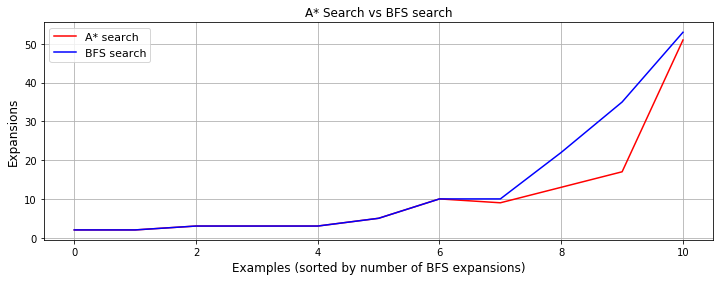

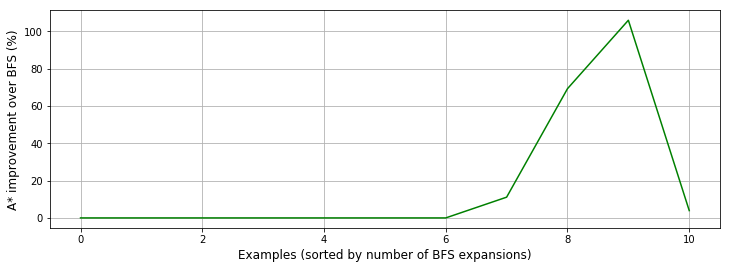

Average A* improvement over BFS: 17.29%.


In [7]:
# Load results from running adversarial search on credit dataset.
results = load_results('../out/credit.pickle')

# First establish which number of quantization bins provides the best improvement.
improvements, binss = [], []

for result in results:
    bins, p_norm, q_norm = result['bins'], result['p_norm'], result['q_norm']
    
    # Ignore p_norm = 2, q_norm = 2 and p_norm = np.inf, q_norm = 1
    if not (p_norm == 1 and q_norm == np.inf):
        continue
        
    ast_results, bfs_results = result['search_results'], result['baseline_results']
    improvement = get_improvement(ast_results=ast_results, bfs_results=bfs_results)
    
    improvements.append(improvement)
    binss.append(bins)
        
arg_max = np.argmax([x[0].mean() for x in improvements])
arg_max_bins = binss[arg_max]
arg_max_improvement = improvements[arg_max]

# Now plot the result for the selected number of bins.
plot_comparison(*arg_max_improvement)